# 等离子体电子声波：Plateau Maxwellian Model

In [333]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy.mathematics
import scipy.signal
import scipy.optimize as op
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
%config InlineBackend.figure_format = 'svg'

## 模型
### 等离子体：运动电子+静止均匀分布离子

In [118]:
# 等离子体基本参数

n = 1
q = 1
m = 1
tem = 1

l_D = np.sqrt( tem / n / q**2 ) # $\lambda_D^2$
v_th = np.sqrt(2 * tem / m)
w_pe = np.sqrt( n * q**2 )

print('l_D = ',l_D)
print('v_th = ',v_th)
print('w_pe = ',w_pe)

l_D =  1.0
v_th =  1.4142135623730951
w_pe =  1.0


### 分布函数
设电子分布函数：plateau-Maxwell分布，即分布函数总体上仍为Maxwell分布
$$ f_m(v) = \frac{1}{\sqrt{\pi} v_{th}} e^{-\frac{v^2}{v_{th}^2} }$$
但在$v=v_0$处，分布函数为一平台（plateau）
$$ \frac{d f(v)}{d v} \Big\vert_{v=v_0} = 0$$

### 色散关系
- 由于电子主体上还是M分布，因此色散关系仍为
$$1 - \frac{1}{ 2 k^2 \lambda_D^2 } Z'(\zeta)=0$$
其中 $\zeta=\frac{\omega}{kv_{th}}$，$v_{th}=\sqrt{\frac{2kT}{m_e}}$

- 唯一不同的地方在$v=v_0$处，如果一列波的波速刚好$w/k = v_0$，那么这列波的色散关系(Vlasov PDR)
$$1 - \frac{1}{ 2 k^2 \lambda_D^2 } Re[Z'(\zeta)]=0$$
由于$f'(v_0) = 0$，因此这是一列无阻尼的波，$Im[Z'(\zeta)] = 0$


- 我们画出Vlasov PDR

In [299]:
def VlasovPDR(w,k):
    zeta = w / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta).real )
    return r

def SolveVlasovPDR(k,w_init_guess):
    s=op.root(lambda w:VlasovPDR(w,k),w_init_guess)
    if s.success == True:
        r = s
    return r

def LandauPDR(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]

def SolveLandauPDR(k,w_init_guess):
    s=op.root(lambda w:LandauPDR(w,k),[1.0,0.1])
    if s.success == True:
        r = s
    return r

k_list = np.linspace(0.1,0.533,num=200,endpoint=True)
w_up_list = np.array([])
w_down_list = np.array([])
w_up_init_guess = 1.0
w_down_init_guess = 0.1

In [300]:
for k in k_list:
    s_up = SolveVlasovPDR(k,w_up_init_guess)
    if s_up.success == True:
        if s_up.x not in w_up_list:
            w_up_list = np.append(w_up_list,s_up.x)
    w_up_init_guess = s_up.x
            
    s_down = SolveVlasovPDR(k,w_down_init_guess)
    if s_down.success == True:
        if s_down.x not in w_down_list:
            w_down_list = np.append(w_down_list,s_down.x)
    w_down_init_guess = s_down.x

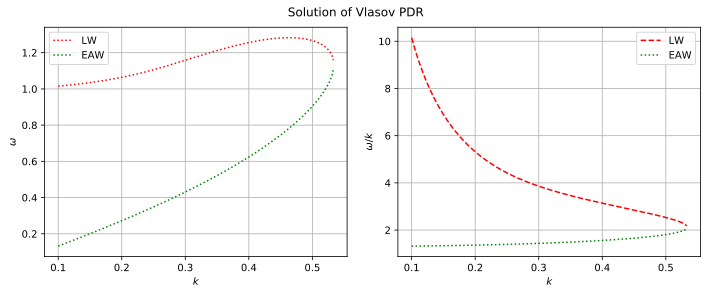

In [301]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.plot(k_list,w_up_list,':',color='r',label='LW')
ax1.plot(k_list,w_down_list,':',color='g',label='EAW')
ax1.legend()
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'$\omega$')
ax1.grid()

v_up_list = w_up_list / k_list
v_down_list = w_down_list / k_list
ax2 = plt.subplot(122)
ax2.plot(k_list,v_up_list,'--',color='r',label='LW')
ax2.plot(k_list,v_down_list,':',color='g',label='EAW')
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$\omega/k$')
ax2.legend()
ax2.grid()

fig.suptitle('Solution of Vlasov PDR',va='bottom')
plt.tight_layout()
plt.show()

- 这个色散关系将预测出两支波，一支为普通Maxwell等离子体中出现的Langmuir波(LW)，另一支波为普通Maxwell等离子体中没有的电子声波 Electron Acoustic Wave(EAW) 

## 构造解析plateau-Maxwell分布函数

- Valentini2012PoP 中构造了plateau-Maxwell分布函数
$$ f_p(v) = N \left\{ f_m(v) - \frac{f_m(v)-f_m(v_0)}{1+[(v-v_0)/\Delta v_p]^{n_p}} \right\} $$
其中$v_0$是平台处速率，$\Delta v_p$是平台宽度，$n_p$是光滑程度
- 其图像为（$v_{th}=\sqrt{2}$, $v_0 = 1.5$, $\Delta v_p = 0.01$, $n_p=10$)

In [712]:
dv_p = 0.01
n_p = 10
v_0 = 1.56036
v_th = np.sqrt(2)

def f_m(v):
    r = np.exp(-v**2/v_th**2) / np.sqrt(np.pi) / v_th
    return r

def f_p_unnorm(v):
    d = 1 + ((v-v_0)/dv_p)**n_p
    n = f_m(v) - f_m(v_0)
    r = f_m(v) - n/d
    return r

norm = integrate.quad(f_p_unnorm,-np.inf,np.inf)[0]

def f_p(v):
    return f_p_unnorm(v)/norm

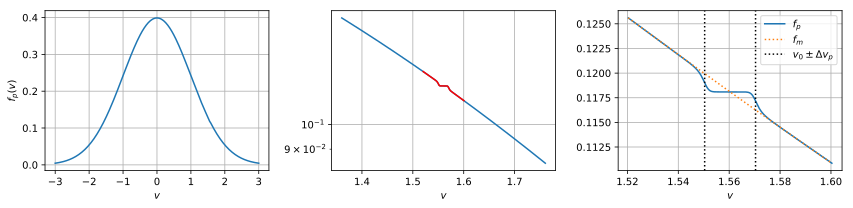

In [713]:
v_global = np.linspace(-3,3,num=200)
v_local_1 = np.linspace(v_0-0.2,v_0+0.2,num=200)
v_local_2 = np.linspace(v_0-dv_p*4,v_0+dv_p*4,num=200)

fig = plt.figure(figsize=(12,3))
ax1 = plt.subplot(131)
ax1.plot(v_global,f_p(v_global))
# ax1.set_yscale('log')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_p(v)$')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(v_local_1,f_p(v_local_1))
ax2.plot(v_local_2,f_p(v_local_2),color='r')
ax2.set_xlabel(r'$v$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot(133)
ax3.plot(v_local_2,f_p(v_local_2),label=r'$f_p$')
ax3.plot(v_local_2,f_m(v_local_2),':',label=r'$f_m$')
ax3.axvline(x=v_0-dv_p,linestyle=':',color='black')
ax3.axvline(x=v_0+dv_p,linestyle=':',color='black',label=r'$v_0 \pm \Delta v_p$')
ax3.set_xlabel(r'$v$')
ax3.legend()
ax3.grid()
plt.tight_layout()
plt.show()

- 不同$\Delta v_p$的分布可允许不同振幅的BGK波，分布中的plateau代表trapped particles，那么在wave frame(参考系以波速运动)下：
$$ \frac{1}{2}m(\Delta v_p)^2 - e \phi \le -e \phi_{max} = 0$$
$$\Delta v_p \le \sqrt{\frac{2e\phi}{m}}$$
若$n = 1+d\cos(kx-\omega t)$,则 $\phi = $ 其中 $\phi_m ~ d/k^2$

### 驱动电场

In [1504]:
def AppliedE(x,t):
    T = 2*np.pi/k/v_0
    dtau = 10*T
    tau = 20*T
    g = 1.0/ (1+(t-tau)**10/dtau**10)
    r = g*np.sin(k*x-k*v_0*t)
    return r

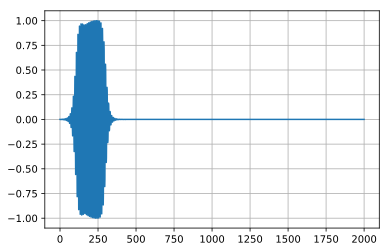

In [1506]:
tt = t[0:2000]
plt.plot(tt,AppliedE(0,tt))
plt.grid()
plt.show()

## 数值验证

### 模拟参数设定

In [1507]:
k = 0.4
L = 2*np.pi/k

vmax = 5 # 速度最大值
nx = 201
nv = 8001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.1
max_steps  = 2000
data_steps = 200
data_num = int(max_steps/data_steps)+1
d = 2e-5
dv_p = 0.01

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

11
limited time= 12566.370614359172
real time =  200.0


- 计算LW和EAW的波速

In [1508]:
wr_lw,wi_lw = SolveLandauPDR(k,[1.0,0.1]).x
w_eaw = SolveVlasovPDR(k,0.3).x[0]
v_eaw = w_eaw/k
v_lw = wr_lw/k
v_0 = v_eaw

In [1509]:
vphi_table = PrettyTable(['k = '+str(k),'wr','wi','wr/k'])
vphi_table.add_row(['LW',round(wr_lw,6),round(wi_lw,6),round(v_lw,6)])
vphi_table.add_row(['EAW',round(w_eaw,6),'-',round(v_eaw,6)])
print(vphi_table)

+---------+----------+-----------+----------+
| k = 0.4 |    wr    |     wi    |   wr/k   |
+---------+----------+-----------+----------+
|    LW   | 1.285057 | -0.066128 | 3.212642 |
|   EAW   | 0.624144 |     -     | 1.56036  |
+---------+----------+-----------+----------+


## 模拟结果

In [1510]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

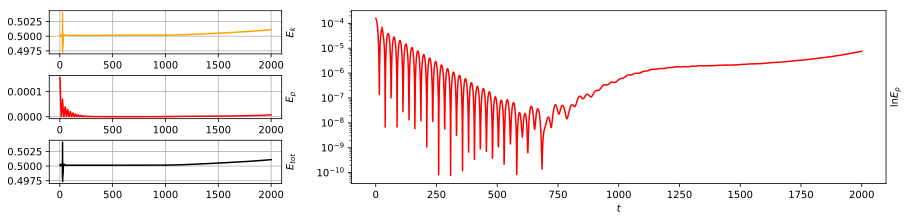

In [1511]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [1512]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [1513]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

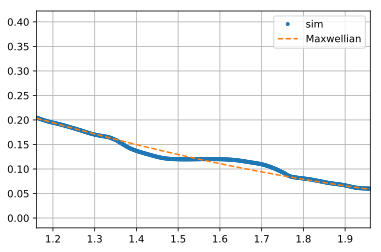

In [1518]:
plt.plot(v,fv,'.',label='sim')
plt.plot(v,f_m(v),'--',label=r'Maxwellian')
plt.xlim(v_eaw-40*dv_p,v_eaw+40*dv_p)
# plt.xlim(v_lw-4*dv_p,v_lw+4*dv_p)
# plt.ylim(0.1150,0.1225)
# plt.ylim(0.003,0.01)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [1515]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//15
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_1$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_2$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()

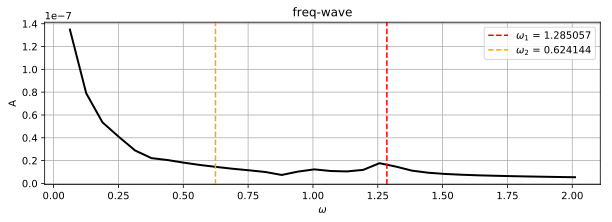

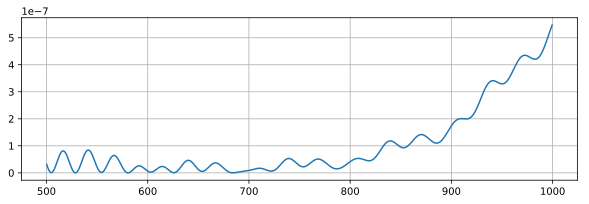

In [1524]:
start = 500
end = 1000
PlotWaveFreq(t[start:end],dataep[start:end],wr_lw,w_eaw)
fig = plt.figure(figsize=(10,3))
plt.plot(t[start:end],dataep[start:end])
plt.grid()
plt.show()

### 同样条件下，初始分布为Maxwell分布的结果

In [1495]:
f0_com = np.loadtxt(os.path.join(path,"data0"))
f_com = np.loadtxt(os.path.join(path,"data"+str(data_num-1)))
fv0_com = np.sum(f0_com,axis=0)*dx/L
fv0_com = np.sum(f_com,axis=0)*dx/L

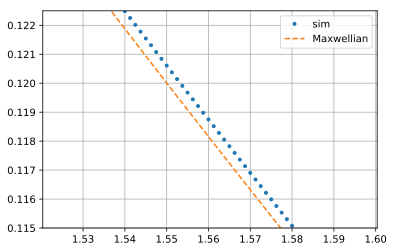

In [1496]:
plt.plot(v,fv0_com,'.',label='sim')
plt.plot(v,f_m(v),'--',label=r'Maxwellian')
plt.xlim(v_eaw-4*dv_p,v_eaw+4*dv_p)
plt.ylim(0.1150,0.1225)
# plt.ylim(0.002,0.0026)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

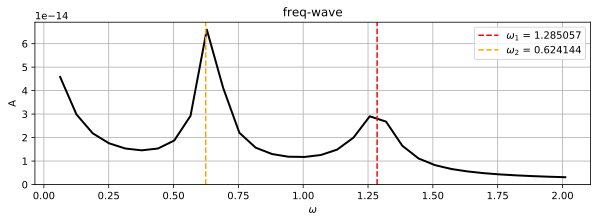

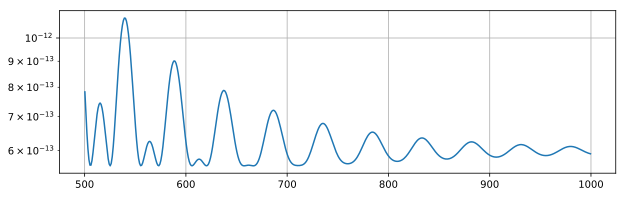

In [1503]:
start = 500
end = 1000
dataep_com =  np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
PlotWaveFreq(t[start:end],dataep_com[start:end],wr_lw,w_eaw)
fig = plt.figure(figsize=(10,3))
plt.plot(t[start:end],dataep_com[start:end])
plt.yscale('log')
plt.grid()
plt.show()